# Ford Go Bike Trip Data (Exploratory Analysis)

##### by Karim El-Dweky

## Preliminary Wrangling

> Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area. It is operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. It was established as Bay Area Bike Share in August 2013. As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose.

> In June 2017 the system was officially re-launched as Ford GoBike in a partnership with Ford Motor Company. After Motivate's acquisition by Lyft, the system was renamed to Bay Wheels in June 2019. The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.

> The dataset used for this exploratory analysis consists of monthly individual trip data during February 2019 in CSV format contain approximately 183,412 rows.

### Introduction
Exploratory data visualization generally occurs during and after the data wrangling process, and is the main method that I will use to understand the patterns and relationships present in FordGoBike trip data. This understanding will help me approach any statistical analyses and will help me build conclusions and findings.

In [2]:
# importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import re
import datetime
import os
import statsmodels.api as sm
import scipy
from functools import reduce
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Data Gathering

- **FordGoBike Trip Data**
    - This file (201902-fordgobike-tripdata.csv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following:
    
    URL: https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv

In [3]:
# Function definition for dataset download

def request_file(url):
    file_name = os.path.basename(url)
    response = requests.get(url)
    # save content of response in the file
    if not os.path.isfile(file_name):
        with open(file_name,'wb') as f:
            f.write(response.content)
    return file_name

In [4]:
# URL downloaded programatically

url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
file_name = request_file(url)

# Reading CSV file

df = pd.read_csv(file_name)
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


### Data Assessment
Data Assessment consists of two main steps (Visual - Programmatic) which help in exploring the gathered data and finding the anamolies points that needs to be cleaned.

#### Visual Assessment

In [5]:
df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183407,480,2019-02-01 00:04:49.7240,2019-02-01 00:12:50.0340,27.0,Beale St at Harrison St,37.788059,-122.391865,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,4832,Subscriber,1996.0,Male,No
183408,313,2019-02-01 00:05:34.7440,2019-02-01 00:10:48.5020,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,66.0,3rd St at Townsend St,37.778742,-122.392741,4960,Subscriber,1984.0,Male,No
183409,141,2019-02-01 00:06:05.5490,2019-02-01 00:08:27.2200,278.0,The Alameda at Bush St,37.331932,-121.904888,277.0,Morrison Ave at Julian St,37.333658,-121.908586,3824,Subscriber,1990.0,Male,Yes
183410,139,2019-02-01 00:05:34.3600,2019-02-01 00:07:54.2870,220.0,San Pablo Ave at MLK Jr Way,37.811351,-122.273422,216.0,San Pablo Ave at 27th St,37.817827,-122.275698,5095,Subscriber,1988.0,Male,No


#### Programmatic Assessment

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [7]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [8]:
df.shape

(183412, 16)

In [9]:
df[df.duplicated()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip


In [10]:
df.member_gender.value_counts()

Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64

In [11]:
df.user_type.value_counts()

Subscriber    163544
Customer       19868
Name: user_type, dtype: int64

In [12]:
df.bike_share_for_all_trip.value_counts()

No     166053
Yes     17359
Name: bike_share_for_all_trip, dtype: int64

In [13]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [14]:
df.isin([0]).sum()

duration_sec               0
start_time                 0
end_time                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
member_birth_year          0
member_gender              0
bike_share_for_all_trip    0
dtype: int64

#### Data Assessment Summary Report

    1. Changing a lot of data types.
    2. Dropping unneeded columns.
    3. Dropping all rows with Nan Values.
    4. Extracting date, day and hour from start time.
    5. Adding a new column calculating members' age from 'member_birth_year'.

### Data Cleaning

#### Taking a copy for cleaning process:

In [15]:
df_cleaned = df.copy()

#### Cleaning Issues:

##### 1. Define:

Changing a lot of data types.

##### Code:

In [16]:
# Changing a lot of data types.

df_cleaned['start_time'] = pd.to_datetime(df_cleaned['start_time'])
df_cleaned['end_time'] = pd.to_datetime(df_cleaned['end_time'])

df_cleaned['bike_id'] = df_cleaned['bike_id'].astype('str')

df_cleaned['user_type'] = df_cleaned['user_type'].astype('category')
df_cleaned['member_gender'] = df_cleaned['member_gender'].astype('category')
df_cleaned['bike_share_for_all_trip'] = df_cleaned['bike_share_for_all_trip'].astype('category')

##### Test:

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183215 non-null  float64       
 4   start_station_name       183215 non-null  object        
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183215 non-null  float64       
 8   end_station_name         183215 non-null  object        
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  object        
 12  user_type       

##### 2. Define:

Dropping unneeded columns.

##### Code:

In [18]:
# Dropping (start_station_id, start_station_latitude, start_station_longitude, end_station_id, end_station_latitude, end_station_longitude) coloumns 

unneeded_coulmns = ['start_station_id',
                    'start_station_latitude',
                    'start_station_longitude',
                    'end_station_id',
                    'end_station_latitude',
                    'end_station_longitude']


df_cleaned.drop(unneeded_coulmns, axis=1, inplace=True)

##### Test:

In [19]:
df_cleaned.head()

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Montgomery St BART Station (Market St at 2nd St),Commercial St at Montgomery St,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,The Embarcadero at Steuart St,Berry St at 4th St,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Market St at Dolores St,Powell St BART Station (Market St at 4th St),5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,Grove St at Masonic Ave,Central Ave at Fell St,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Frank H Ogawa Plaza,10th Ave at E 15th St,4898,Subscriber,1974.0,Male,Yes


In [20]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_name       183215 non-null  object        
 4   end_station_name         183215 non-null  object        
 5   bike_id                  183412 non-null  object        
 6   user_type                183412 non-null  category      
 7   member_birth_year        175147 non-null  float64       
 8   member_gender            175147 non-null  category      
 9   bike_share_for_all_trip  183412 non-null  category      
dtypes: category(3), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 10.3+ MB


##### 3. Define:

Dropping all rows with Nan Values.

##### Code:

In [21]:
# Dropping all rows with Nan Values.

df_cleaned.dropna(axis = 0, inplace = True)

##### Test:

In [22]:
df_cleaned.shape

(174952, 10)

In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_name       174952 non-null  object        
 4   end_station_name         174952 non-null  object        
 5   bike_id                  174952 non-null  object        
 6   user_type                174952 non-null  category      
 7   member_birth_year        174952 non-null  float64       
 8   member_gender            174952 non-null  category      
 9   bike_share_for_all_trip  174952 non-null  category      
dtypes: category(3), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 11.2+ MB


##### 4. Define:

Extracting date, day and hour from start time.

##### Code:

In [24]:
# Extracting date, day and hour from start time.

df_cleaned['start_date'] = df_cleaned['start_time'].dt.strftime('%Y-%m-%d')
df_cleaned['start_day']= df_cleaned['start_time'].dt.strftime('%a')
df_cleaned['start_hour'] = df_cleaned['start_time'].dt.strftime('%H')

##### Test:

In [25]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_name       174952 non-null  object        
 4   end_station_name         174952 non-null  object        
 5   bike_id                  174952 non-null  object        
 6   user_type                174952 non-null  category      
 7   member_birth_year        174952 non-null  float64       
 8   member_gender            174952 non-null  category      
 9   bike_share_for_all_trip  174952 non-null  category      
 10  start_date               174952 non-null  object        
 11  start_day                174952 non-null  object        
 12  start_hour      

In [26]:
df_cleaned.head()

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_date,start_day,start_hour
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Montgomery St BART Station (Market St at 2nd St),Commercial St at Montgomery St,4902,Customer,1984.0,Male,No,2019-02-28,Thu,17
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Market St at Dolores St,Powell St BART Station (Market St at 4th St),5905,Customer,1972.0,Male,No,2019-02-28,Thu,12
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,Grove St at Masonic Ave,Central Ave at Fell St,6638,Subscriber,1989.0,Other,No,2019-02-28,Thu,17
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Frank H Ogawa Plaza,10th Ave at E 15th St,4898,Subscriber,1974.0,Male,Yes,2019-02-28,Thu,23
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,4th St at Mission Bay Blvd S,Broadway at Kearny,5200,Subscriber,1959.0,Male,No,2019-02-28,Thu,23


##### 5. Define:

Adding a new column calculating members' age from 'member_birth_year'.

##### Code:

In [27]:
# Adding a new column calculating members' age from 'member_birth_year'.

df_cleaned['member_age'] = 2019 - df_cleaned['member_birth_year']

##### Test:

In [28]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_name       174952 non-null  object        
 4   end_station_name         174952 non-null  object        
 5   bike_id                  174952 non-null  object        
 6   user_type                174952 non-null  category      
 7   member_birth_year        174952 non-null  float64       
 8   member_gender            174952 non-null  category      
 9   bike_share_for_all_trip  174952 non-null  category      
 10  start_date               174952 non-null  object        
 11  start_day                174952 non-null  object        
 12  start_hour      

In [29]:
df_cleaned.head()

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_date,start_day,start_hour,member_age
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Montgomery St BART Station (Market St at 2nd St),Commercial St at Montgomery St,4902,Customer,1984.0,Male,No,2019-02-28,Thu,17,35.0
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Market St at Dolores St,Powell St BART Station (Market St at 4th St),5905,Customer,1972.0,Male,No,2019-02-28,Thu,12,47.0
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,Grove St at Masonic Ave,Central Ave at Fell St,6638,Subscriber,1989.0,Other,No,2019-02-28,Thu,17,30.0
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Frank H Ogawa Plaza,10th Ave at E 15th St,4898,Subscriber,1974.0,Male,Yes,2019-02-28,Thu,23,45.0
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,4th St at Mission Bay Blvd S,Broadway at Kearny,5200,Subscriber,1959.0,Male,No,2019-02-28,Thu,23,60.0


### Data Storing

In [30]:
# Storing the cleaned DataFrame in a CSV file

df_cleaned.to_csv('fordgobike-cleaned.csv', index = False, encoding = 'utf-8')

### What is the structure of your dataset?

> The structure of my dataset is 13 coloumns with 174,952 trip record. Each trip can be summarized in 4 categories:
   
>    - **Trip Duration Data:** [duration_sec, start_time, end_time, start_date, start_day, start_hour].
    - **Station Data:** [start_station_name, end_station_name]
    - **Bike Data:** [bike_id, bike_share_for_all_trip]
    - **Member Data:** [user_type, member_birth_year, member_gender, member_age]


### What is/are the main feature(s) of interest in your dataset?

> **The main features of interest are** the bike trips' duration and rental events occurrance patterns, along with how these relate to the members' characteristics, to get a sense of how and what people are using the bike sharing service for. 

> **Questions needs answer:**
    - When are most trips taken in terms of time of day or day of the week?
    - How long does the average trip take? 
    - Does the above depend on if a user is a subscriber or customer?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> **The features that will support my investigation are**
    - Trips Duration Data will help understanding how long a trip usually takes and when. 
    - Members Data like user type, gender and age will help us find out the main target customer groups, 
    - Using different type of data groups to summarize bike usage data to see if there is any special pattern associated with a specific group of members.

## Univariate Exploration

> In this section, I will investigate distributions of individual variables to see unusual points or outliers, take a deeper look to clean things up and prepare myself to look at relationships between variables.

### 1. Age Distribution Per Members

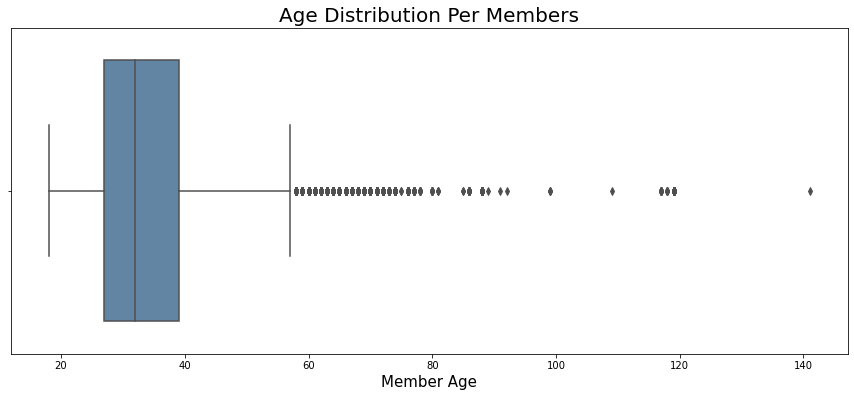

In [31]:
# plotting of Age Distribution Per Members

plt.figure(figsize=(15,6))
sb.boxplot(x = df_cleaned.member_age, color='#5885AF')
plt.xlabel('Member Age', fontsize=15)
plt.title("Age Distribution Per Members", fontsize=20);

> **The figure shows that there is outliers over age 52 for Memebers should be cleaned**

In [32]:
# Cleaning age outliers 

df_cleaned=df_cleaned[df_cleaned.member_age <= 52]

In [33]:
# Test

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163341 entries, 0 to 183411
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             163341 non-null  int64         
 1   start_time               163341 non-null  datetime64[ns]
 2   end_time                 163341 non-null  datetime64[ns]
 3   start_station_name       163341 non-null  object        
 4   end_station_name         163341 non-null  object        
 5   bike_id                  163341 non-null  object        
 6   user_type                163341 non-null  category      
 7   member_birth_year        163341 non-null  float64       
 8   member_gender            163341 non-null  category      
 9   bike_share_for_all_trip  163341 non-null  category      
 10  start_date               163341 non-null  object        
 11  start_day                163341 non-null  object        
 12  start_hour      

In [34]:
# Storing the cleaned DataFrame in a CSV file

df_cleaned.to_csv('fordgobike-cleaned.csv', index = False, encoding = 'utf-8')

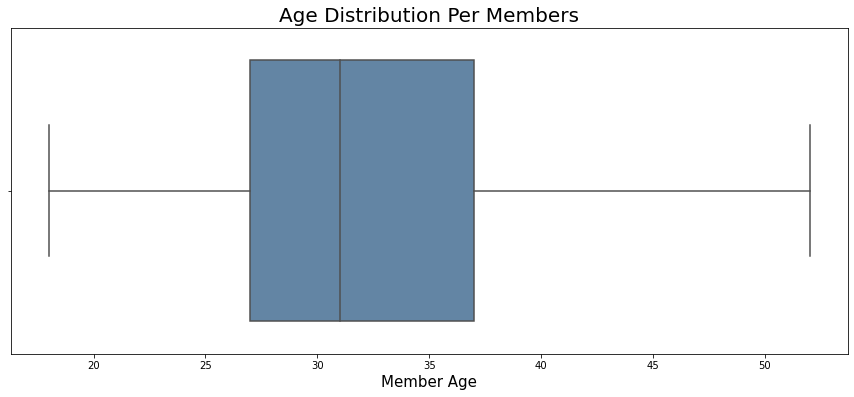

In [35]:
plt.figure(figsize=(15,6))
sb.boxplot(x = df_cleaned.member_age, color='#5885AF')
plt.xlabel('Member Age', fontsize=15)
plt.title("Age Distribution Per Members", fontsize=20);

> **The figure is for testing that the outliers are successfully removed.**

### 2. Count And Percentage Of Each User Type 

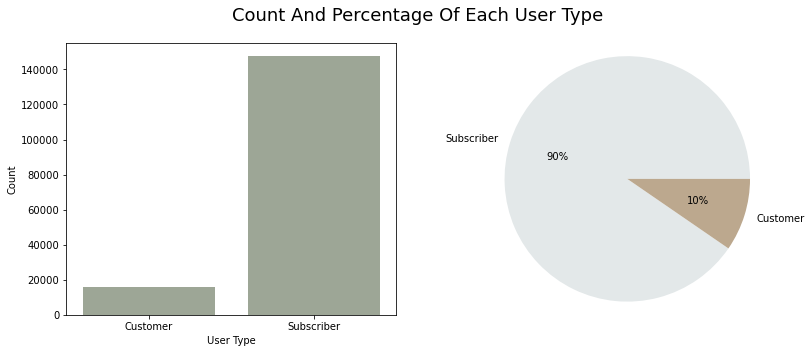

In [36]:
# Plotting Count And Percentage Of Each User Type

plt.figure(figsize = [13, 5])

plt.subplot(1, 2, 1)
sb.countplot(x = df_cleaned.user_type, color = '#9DA993')
plt.xlabel('User Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(df_cleaned.user_type.value_counts(),
        labels = df_cleaned.user_type.value_counts().keys(), 
        colors = ['#E3E8E9', '#BCA88E'],
        autopct='%1.0f%%')
        
plt.axis('equal')

plt.suptitle('Count And Percentage Of Each User Type', fontsize=18);

> **The figure shows that The users majority are Subscribers with 90% while Customers are only 10%.**

### 3. Count And Percentage Of Each Member Gender

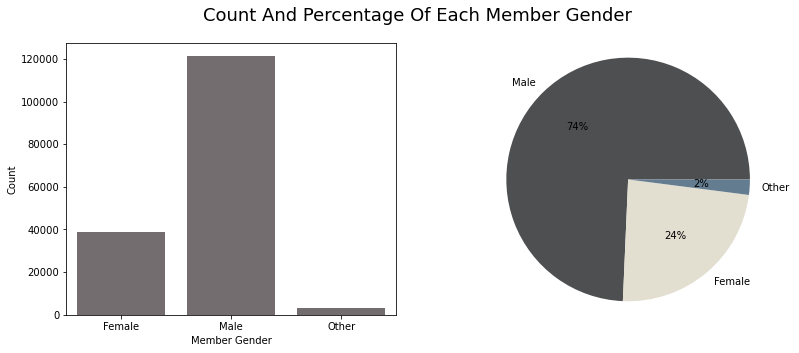

In [37]:
# Plotting Count And Percentage Of Each Member Gender

plt.figure(figsize = [13, 5])

plt.subplot(1, 2, 1)
sb.countplot(x = df_cleaned.member_gender, color = '#746C70')
plt.xlabel('Member Gender')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(df_cleaned.member_gender.value_counts(),
        labels = df_cleaned.member_gender.value_counts().keys(), 
        colors = ['#4E4F50', '#E2DED0', '#647C90'],
        autopct='%1.0f%%')
        
plt.axis('equal')

plt.suptitle('Count And Percentage Of Each Member Gender', fontsize=18);

> **The figure shows that The Users majority are Males with 74% while Females are only 24% and Others are 2%.**

### 3. Trip Count Per Week Days

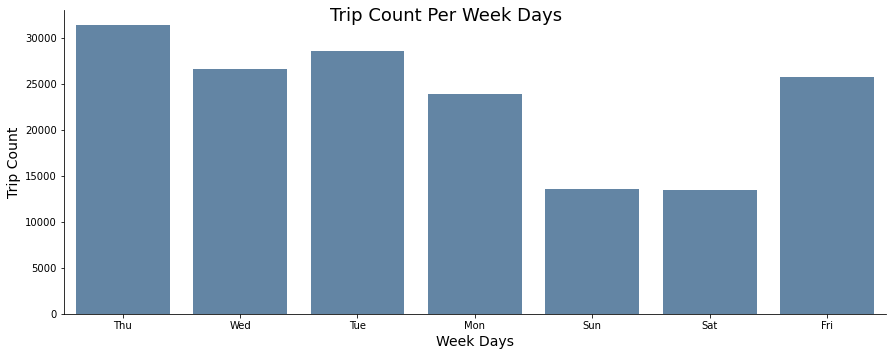

In [41]:
# Plotting Trip Count Per Week Days

sb.catplot(x = 'start_day', data = df_cleaned, kind = 'count', color = '#5885AF', height=5, aspect=2.5)
plt.xlabel('Week Days', size=14)
plt.ylabel('Trip Count', size=14)
plt.tight_layout()
plt.suptitle('Trip Count Per Week Days', fontsize=18);

> **The figure shows that Rental at the minimum in weekends and reach higher values during working days and the peak is in Thursday.**

### 4. Trip Count vs. Hour Of The Day

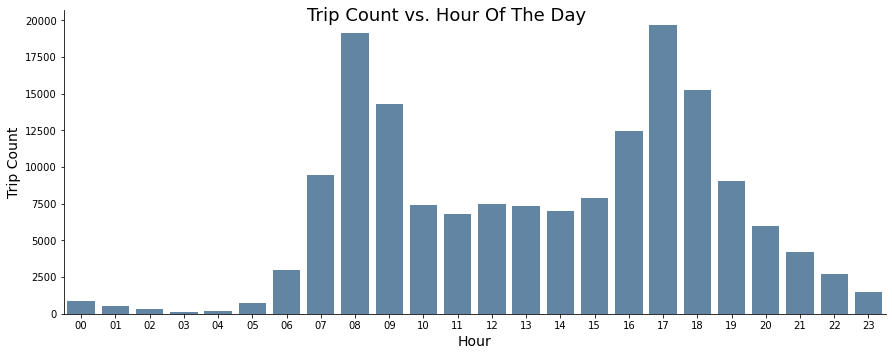

In [39]:
# Trip Count vs. Hour Of The Day

df_sorted = df_cleaned.sort_values(by = 'start_hour', ascending = True)
sb.catplot(x = 'start_hour', data = df_sorted, kind = 'count', color = '#5885AF', height=5, aspect=2.5)
plt.xlabel('Hour', size=14)
plt.ylabel('Trip Count', size=14)
plt.tight_layout()
plt.suptitle('Trip Count vs. Hour Of The Day', fontsize=18);

> **The figure showing that the sevice demand peak during 8 am and 5 pm perhapes because the majority of people going and leaving work at those times.**

### 5. Age Count

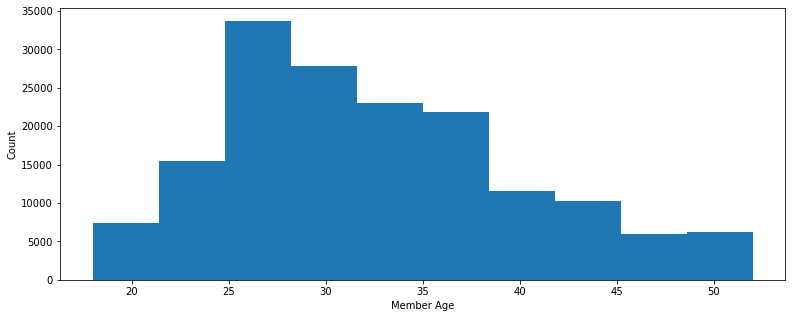

In [44]:
# Age Count 

plt.figure(figsize = [13, 5])
plt.hist(x = 'member_age', data = df_cleaned)
plt.xlabel('Member Age');
plt.ylabel('Count');

> **The figure show that the majority service users are between 25 - 30 of age.**

### 6. High Demand Stations

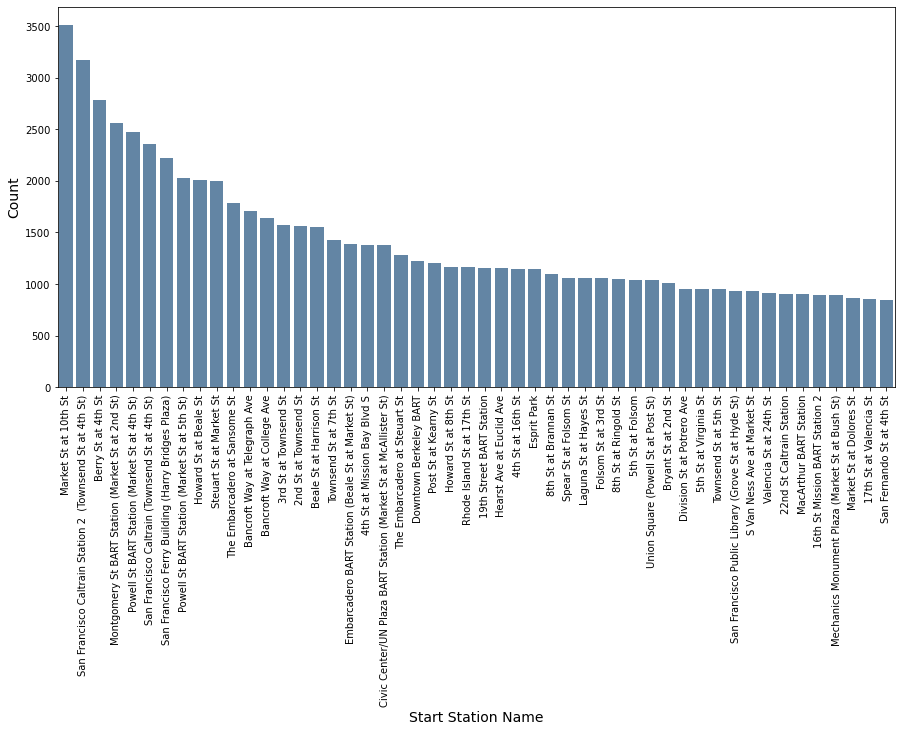

In [54]:
# Plot of High Demand Stations

plt.figure(figsize = [15, 7])
sb.countplot(x = 'start_station_name', data = df_cleaned, color = '#5885AF', 
             order = df_cleaned.start_station_name.value_counts(ascending=False)[0:50].index)
plt.xlabel('Start Station Name', fontsize=14)
plt.ylabel('Count', fontsize=14);
plt.xticks(rotation = 90, size = 10);

> **The figure shows that the top 50 high demand stations which needed by the supplier in order to make sure those stations are always equipped with the requested bikes.**

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!